In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime

# **Import Dataset**

In [ ]:
# import dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv'

df_raw = pd.read_csv(url,names=["Age", "Workclass", "Final Weight", "Education", "Education Number of Years", "Marital-status",
                            "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss","Hours-per-week", "Native-country",
                            "Target"], na_values='?')

# **Data Pre-processing**

In [ ]:
df=df_raw.copy()
# let´s find rows with missing data
na_columns=df.columns[df.isna().any()].tolist()
# and replace them with the mode
df[na_columns] = df[na_columns].apply(lambda x: x.fillna(x.mode()[0]))
# drop Final Weight
df.drop('Final Weight', axis=1, inplace=True)
# drop Education as it correlates with Education Number of Years
df.drop('Education', axis=1, inplace=True)
# drop Native-country
df.drop('Native-country', axis=1, inplace=True)
# label encode target
mapping={"<=50K":0,
         '>50K':1}
df.loc[:,"Target"]=df["Target"].map(mapping)
# identify feature list
features=[f for f in df.columns if f not in ("Target")]
# select categorical and numerical features
cat_ix = df[features].select_dtypes(include=['object', 'bool']).columns
num_ix = df[features].select_dtypes(include=['int64', 'float64']).columns

In [ ]:
# simplifing no of categories
# workclass will have only 4 (instead of 7)
mapping_workclass={'State-gov':"Public",
                   'Self-emp-not-inc':"Self",
                   'Private':"Private",
                   'Federal-gov':"Public",
                   'Local-gov': "Public",
                   'Self-emp-inc':"Self",
                   "Without-pay":"Without-pay"}
# marital status will have only 4 (instead of 7)                   
mapping_marital={'Married-civ-spouse':"Married",
                  'Married-spouse-absent':"Divorced",
                  'Married-AF-spouse': "Married",
                   'Never-married':"Single",
                 'Separated':"Divorced",
                 'Divorced':'Divorced',
                 'Widowed':"Widowed"}
df.loc[:,"Workclass"]=df["Workclass"].map(mapping_workclass)
df.loc[:,"Marital-status"]=df["Marital-status"].map(mapping_marital)
# simplify Race 
not_white=df["Race"].loc[df["Race"]!='White'].to_list()
df['Race']=df['Race'].replace(not_white,"Not Whites")
# # split the dataframe into X and y
X=df.loc[:, df.columns != 'Target']
y=df.loc[:,'Target']

# **Perform Scaling and One-Hot**

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",StandardScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore",sparse=False),cat_ix)])
X_=transformation_pipeline.fit_transform(X)

# **PCA then K-means or K-means then PCA?**

# **Find Clusters on Original Dataset**

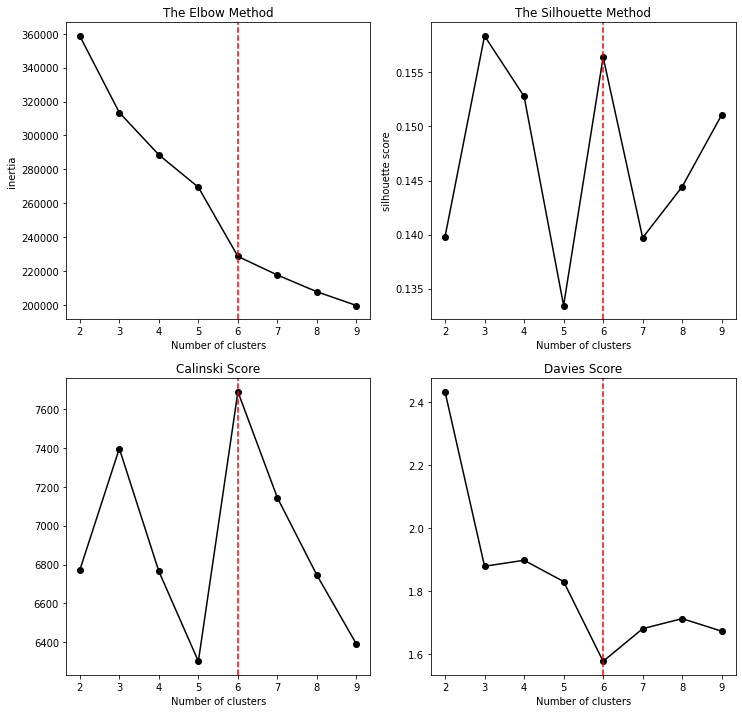

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

inertia = []
silh=[]
cali=[]
davis=[]
max_clust=9
for i in range(2, max_clust+1):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X_)
    # data for the elbow method
    inertia.append(kmeans.inertia_)
    # data for the silhouette score method
    silh.append(silhouette_score(X_, kmeans.labels_))
    # data for calinski score
    cali.append(calinski_harabasz_score(X_,kmeans.labels_))
    # data dor davis score
    davis.append(davies_bouldin_score(X_,kmeans.labels_))

# plot elbow method and
# silhouette score
fig=plt.figure(figsize=(12,12))
ax1=plt.subplot(221)
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)

ix=max_clust+1
ax1.plot(range(2,ix), inertia,'ko-')
ax1.set_title('The Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('inertia')
ax1.axvline(6, ls="--", c="red")

ax2.plot(range(2,ix), silh,'ko-')
ax2.set_title('The Silhouette Method')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('silhouette score')
ax2.axvline(6, ls="--", c="red")

ax3.plot(range(2,ix), cali,'ko-')
ax3.set_title('Calinski Score')
ax3.set_xlabel('Number of clusters')
ax3.axvline(6, ls="--", c="red")

ax4.plot(range(2,ix), davis,'ko-')
ax4.set_title('Davies Score')
ax4.set_xlabel('Number of clusters')
ax4.axvline(6, ls="--", c="red")

# Perform k-means clustering on original dataset

In [ ]:
# initialise and fit K-Means mode with predefined # of clusters
n_clust=6
km = KMeans(n_clusters=n_clust, init='k-means++').fit(X_)

# Visualize clusters using PCA

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


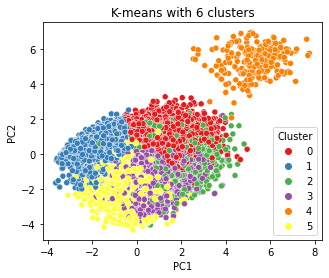

In [ ]:
# visualize clusters in 2-Dimensions using PCA
# invoke PCA with 2 components for visualization 
pca = PCA(n_components=2)
# define model pipeline: data transformation then PCA
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("pca",pca)])
Z=model_pipeline.fit_transform(X)
# setup viz dataframe
# store PCs to dataframe
df=pd.DataFrame(Z,columns=["PC1","PC2"])
# append labels to points
df.loc[:,'Cluster'] = km.labels_ 
# plot clusters
fig1, axes = plt.subplots(1,1,figsize=(5,4))
axes.set_title(f"K-means with {n_clust} clusters")
sns.scatterplot('PC1', 'PC2', data=df,
                hue='Cluster', ax=axes, palette='Set1', legend='full')



---



# **Find out # of PCs in Original Dataset**

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",StandardScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore",sparse=False),cat_ix)])
X_=transformation_pipeline.fit_transform(X)

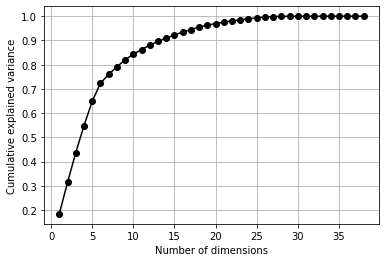

In [ ]:
# invoke PCA 
pca = PCA()
# apply PCA to X_
pca.fit_transform(X_)
# explained variance ratio
exp_var_pca=np.sum(pca.explained_variance_ratio_)
plt.plot(np.arange(1,X_.shape[1]+1),np.cumsum(pca.explained_variance_ratio_),'ko-')
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative explained variance')
plt.grid()

# **Perform PCA with 15 components to preserve 90% variance**

In [ ]:
from sklearn.decomposition import PCA
# feature transformation for numericals
num_pipeline=Pipeline([("minmax_scaler",StandardScaler())])
# apply MinMax to numericals and OneHot to categoricals
transformation_pipeline=ColumnTransformer([("num",num_pipeline,num_ix),
                                           ("cat",OneHotEncoder(handle_unknown = "ignore",sparse=False),cat_ix)])
# invoke PCA 
pca = PCA(n_components=15)
# define model pipeline: data transformation then PCA
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("pca",pca)])
Z=model_pipeline.fit_transform(X)

# **Find Clusters in Z**

# Apply elbow and silhouette method

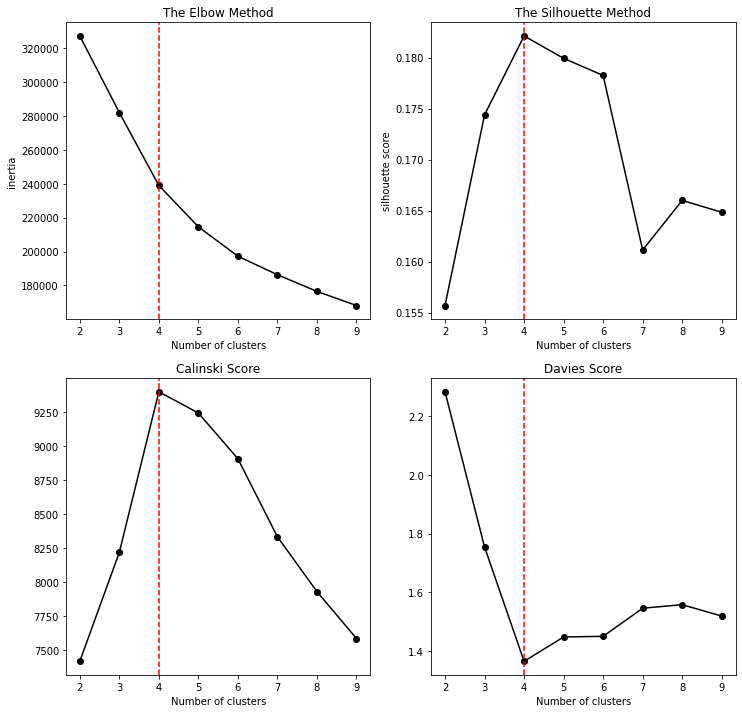

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

inertia = []
silh=[]
cali=[]
davis=[]
max_clust=9
for i in range(2, max_clust+1):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(Z)
    # data for the elbow method
    inertia.append(kmeans.inertia_)
    # data for the silhouette score method
    silh.append(silhouette_score(Z, kmeans.labels_))
    # data for calinski score
    cali.append(calinski_harabasz_score(Z,kmeans.labels_))
    # data dor davis score
    davis.append(davies_bouldin_score(Z,kmeans.labels_))

# plot elbow method and
# silhouette score
fig=plt.figure(figsize=(12,12))
ax1=plt.subplot(221)
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)

ix=max_clust+1
ax1.plot(range(2,ix), inertia,'ko-')
ax1.set_title('The Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('inertia')
ax1.axvline(4, ls="--", c="red")

ax2.plot(range(2,ix), silh,'ko-')
ax2.set_title('The Silhouette Method')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('silhouette score')
ax2.axvline(4, ls="--", c="red")

ax3.plot(range(2,ix), cali,'ko-')
ax3.set_title('Calinski Score')
ax3.set_xlabel('Number of clusters')
ax3.axvline(4, ls="--", c="red")

ax4.plot(range(2,ix), davis,'ko-')
ax4.set_title('Davies Score')
ax4.set_xlabel('Number of clusters')
ax4.axvline(4, ls="--", c="red")

# Perform clustering in Z

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


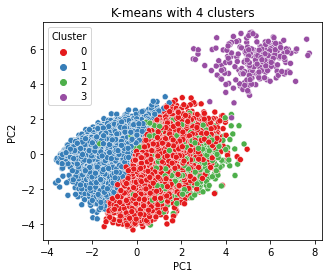

In [ ]:
import seaborn as sns
# initialise and fit K-Means model
km = KMeans(n_clusters=4, init='k-means++').fit(Z)
# invoke PCA with 2 components for visualization 
pca = PCA(n_components=2)
# define model pipeline: data transformation then PCA
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("pca",pca)])
Z=model_pipeline.fit_transform(X)
# store PCs to dataframe
df=pd.DataFrame(Z,columns=["PC1","PC2"])
# append labels to points
df.loc[:,'Cluster'] = km.labels_ 
# plot clusters
fig1, axes = plt.subplots(1,1,figsize=(5,4))
axes.set_title("K-means with 4 clusters")
sns.scatterplot('PC1', 'PC2', data=df,
                hue='Cluster', ax=axes, palette='Set1', legend='full')

In [ ]:
# check cluster size
kmeans_clust_size = df.groupby('Cluster').size().to_frame()
kmeans_clust_size.columns = ["Cluster size"]
kmeans_clust_size

,Cluster size
Cluster,
0,25434
1,20927
2,2237
3,244


Text(0.5, 0, 'pc3')

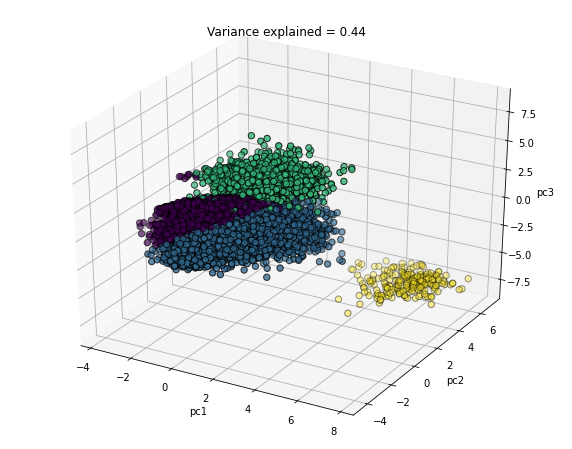

In [ ]:
# invoke PCA with 3 components for visualization 
pca = PCA(n_components=3)
# define model pipeline: data transformation then PCA
model_pipeline=Pipeline([("transformer",transformation_pipeline),
                         ("pca",pca)])
Z=model_pipeline.fit_transform(X)
# initialise and fit K-Means model
km = KMeans(n_clusters=4, init='k-means++').fit(Z)
# store PCs to dataframe
df=pd.DataFrame(Z,columns=["PC1","PC2","PC3"])
# append labels to points
df.loc[:,'Cluster'] = km.labels_ 
# plot clusters
# set up array for 3d plot
data=[Z[:,0],Z[:,1],Z[:,2]]
data=np.array(data)
data=np.transpose(data)
x, y, z = zip(*data)
# plot 3D figure
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,c=df['Cluster'], s=40,edgecolors=(0,0,0))
ax.set_title(f"Variance explained = {np.round(np.sum(pca.explained_variance_ratio_),2)}");
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')